# 데이터 증강

In [3]:
!unzip real_data.zip

Archive:  real_data.zip
   creating: content/data/
   creating: content/data/3/
  inflating: content/data/3/3_1_masked.JPG  
  inflating: content/data/3/3_3_masked.JPG  
  inflating: content/data/3/3_2_masked.JPG  
   creating: content/data/.ipynb_checkpoints/
   creating: content/data/2/
  inflating: content/data/2/2_2_masked.JPG  
  inflating: content/data/2/2_3_masked.JPG  
  inflating: content/data/2/2_1_masked.JPG  
   creating: content/data/1/
  inflating: content/data/1/1_1_masked.JPG  
   creating: content/data/1/.ipynb_checkpoints/
  inflating: content/data/1/1_3_masked.JPG  
  inflating: content/data/1/1_2_masked.JPG  
   creating: content/data/4/
  inflating: content/data/4/4_2_masked.JPG  
   creating: content/data/4/.ipynb_checkpoints/
  inflating: content/data/4/4_3_masked.JPG  
  inflating: content/data/4/4_1_masked.JPG  
   creating: content/data/0/
  inflating: content/data/0/0_1_masked.JPG  
  inflating: content/data/0/0_3_masked.JPG  
  inflating: content/data/0/0_2_

In [4]:
import os
os.chdir('content/data')

In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_images = 15

In [6]:
X = []
y = []

for label in os.listdir():
  if '.' in label: continue
  image_batch = []
  for item in os.listdir(label):
    if 'JPG' not in item.upper(): continue
    fig = cv2.imread(label + '/' + item)
    image_batch.append(fig)
    print(item, fig.shape)
  image_batch = np.array(image_batch)
  data_generator = ImageDataGenerator(
    horizontal_flip=False, vertical_flip=False, rotation_range=180,
    fill_mode='constant', zoom_range=[0.5,1.5], brightness_range=(0.8,1.2),
    channel_shift_range=125
  )
  data_generator.fit(image_batch)

  data_gen_iter = data_generator.flow(image_batch)
  X.append(image_batch)
  y += [int(label)] * image_batch.shape[0]

  for i in range(n_images):
    aug_image_batch = next(data_gen_iter)
    aug_image = aug_image_batch.reshape(-1, 600, 600, 3)
    aug_image = aug_image.astype('int')
    X.append(aug_image)
    y += [int(label)] * aug_image.shape[0]

4_1_masked.JPG (600, 600, 3)
4_3_masked.JPG (600, 600, 3)
4_2_masked.JPG (600, 600, 3)
5_3_masked.JPG (600, 600, 3)
5_2_masked.JPG (600, 600, 3)
5_1_masked.JPG (600, 600, 3)
2_3_masked.JPG (600, 600, 3)
2_2_masked.JPG (600, 600, 3)
2_1_masked.JPG (600, 600, 3)
-2_3_masked.JPG (600, 600, 3)
-2_2_masked.JPG (600, 600, 3)
1_1_masked.JPG (600, 600, 3)
1_2_masked.JPG (600, 600, 3)
1_3_masked.JPG (600, 600, 3)
0_3_masked.JPG (600, 600, 3)
0_1_masked.JPG (600, 600, 3)
0_2_masked.JPG (600, 600, 3)
-1_3_masked.JPG (600, 600, 3)
-1_1_masked.JPG (600, 600, 3)
-1_2_masked.JPG (600, 600, 3)
3_2_masked.JPG (600, 600, 3)
3_1_masked.JPG (600, 600, 3)
3_3_masked.JPG (600, 600, 3)


In [7]:
total = sum(item.shape[0] for item in X)
total

368

In [8]:
images = np.empty((total, 600, 600, 3))
curr_idx = 0

for i in range(len(X)):
  images[curr_idx:curr_idx+X[i].shape[0]] = X[i]
  curr_idx += X[i].shape[0]

In [9]:
X = images
del images
X.shape

(368, 600, 600, 3)

In [10]:
import gc
gc.collect()

0

# CNN 모델 구성

## 시뮬레이션 데이터에 대한 CNN 모델 구성

시뮬레이션 데이터 불러오기

In [11]:
import numpy as np

X = X/255
y = np.array(y)
print(X.shape, y.shape)

(368, 600, 600, 3) (368,)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=X.shape[1:]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 598, 598, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 598, 598, 32)      128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 598, 598, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 299, 299, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 297, 297, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 297, 297, 64)     

In [19]:
import gc
gc.collect()

1816

In [34]:
np.save('X.npy', X)
np.save('y.npy', y)

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.8, verbose=1)

In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6), loss='mse', metrics=['mae', 'mse'])

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
history = model.fit(X_train, y_train, epochs=128, batch_size=20, validation_data=[X_test, y_test], callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/128
15/15 [==============================] - 8s 460ms/step - loss: 5.3483 - mae: 1.9244 - mse: 5.3483 - val_loss: 8.9589 - val_mae: 2.4342 - val_mse: 8.9589 - lr: 1.0000e-06
Epoch 2/128
15/15 [==============================] - 6s 393ms/step - loss: 4.0694 - mae: 1.6849 - mse: 4.0694 - val_loss: 8.4011 - val_mae: 2.3861 - val_mse: 8.4011 - lr: 1.0000e-06
Epoch 3/128
15/15 [==============================] - 5s 315ms/step - loss: 3.0050 - mae: 1.3960 - mse: 3.0050 - val_loss: 8.4040 - val_mae: 2.3836 - val_mse: 8.4040 - lr: 1.0000e-06
Epoch 4/128
15/15 [==============================] - 6s 389ms/step - loss: 2.6175 - mae: 1.3024 - mse: 2.6175 - val_loss: 7.2667 - val_mae: 2.2732 - val_mse: 7.2667 - lr: 1.0000e-06
Epoch 5/128
15/15 [==============================] - 6s 389ms/step - loss: 2.3761 - mae: 1.1994 - mse: 2.3761 - val_loss: 6.3289 - val_mae: 2.1600 - val_mse: 6.3289 - lr: 1.0000e-06
Epoch 6/128
15/15 [==============================] - 5s 318ms/step - loss: 2.4605 - mae: 1

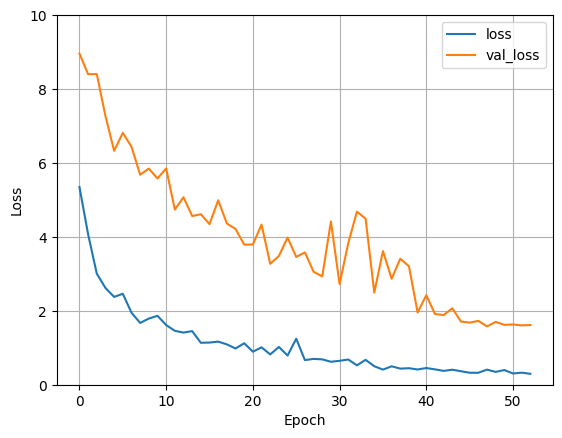

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
print(model.predict(X_test[:10]).reshape(-1), y_test[:10], sep='\n')

1/1 [==============================] - 1s 1s/step
[1.2400501  3.959695   2.4088356  0.01270965 4.0583863  1.9095626
 5.3847895  0.25252202 0.15047577 1.0099423 ]
[-2  4  4 -1  5  1  5  2 -2  2]


In [27]:
model.save('model.h5')